In [42]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
from torch import Tensor
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from copy import deepcopy
from math import prod

# %matplotlib inline
torch.cuda.set_device(0)
torch.cuda.empty_cache()

In [43]:
DATA_DIR = "../../data/dss/"
CHAR_DATA_DIR = DATA_DIR + "monkbrill/"
IMG_DATA_DIR = DATA_DIR + "train-imgs/"

In [44]:
image_size = 64
batch_size = 256
latent_size = image_size ** 2
stats = (0.5,), (0.5,)

train_ds = ImageFolder(CHAR_DATA_DIR, transform=tt.Compose([tt.Grayscale(num_output_channels=1),
                                                            tt.RandomInvert(p=1),
                                                            tt.Resize(image_size),
                                                            tt.CenterCrop(image_size),
                                                            tt.ToTensor(),
                                                            tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [45]:
char_gen = nn.Sequential(
  # in: latent_size x 1 x 1

  nn.ConvTranspose2d(64**2, 512, kernel_size=4, stride=1, padding=0, bias=False),
  nn.BatchNorm2d(512),
  nn.ReLU(True),
  # out: 512 x 4 x 4

  nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(256),
  nn.ReLU(True),
  # out: 256 x 8 x 8

  nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(True),
  # out: 128 x 16 x 16

  nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(True),
  # out: 64 x 32 x 32

  nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
  nn.Tanh()
  # out: 1 x 64 x 64
)

char_gen.load_state_dict(torch.load('./trained/char/generator'))


<All keys matched successfully>

In [52]:
class CorruptWordGen():
  
  def __init__(self, *args, max_iter=2048, **kwargs):
    self.dl_args = args
    self.dl_kwargs = {**kwargs, "batch_size": 1}
    self.n_iter = 0
    self.max_iter = max_iter
    self.data_loader = None
  
  def __iter__(self):
    self.n_iter = 0
    self.data_loader = None
    return self
  
  def __next__(self):
    if self.n_iter > self.max_iter:
      raise StopIteration
    
    if self.data_loader is None:
      self.data_loader = iter(DataLoader(*self.dl_args, **self.dl_kwargs))
    
    try:
      base_img = next(self.data_loader)
      base_img_lab = base_img[1]
      base_img = base_img[0][0][0]
      # subtr_img = next(self.data_loader)[0][0][0]
      # crpt_img = base_img - (subtr_img + 1)
      # crpt_img = torch.maximum(crpt_img, -torch.ones(*crpt_img.shape))
      
      self.n_iter += 1
      
      return char_gen(base_img.reshape((1, latent_size, 1, 1))).reshape((image_size, image_size)), base_img_lab
      # return base_img, base_img_lab
      
    except StopIteration:
      self.data_loader = None
      return next(self)
    
  def gen_chars(self, num=1):
    crpt_imgs = [next(self) for _ in range(num)]
    return tuple([torch.stack([img[i] for img in crpt_imgs]) for i in range(len(crpt_imgs[0]))])
  
  def gen_words(self, num=1):
    chars, labs = self.gen_chars(5)
    print(chars.shape)
    return torch.cat(tuple(chars), dim=1).detach().numpy()
  
  # torch.stack([img[0] for img in crpt_imgs]), \
  #          torch.stack([])
  #          torch.stack([img[1] for img in crpt_imgs])

cwg = iter(CorruptWordGen(deepcopy(train_ds), shuffle=True, num_workers=0, pin_memory=True))

torch.Size([5, 64, 64])


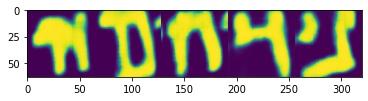

In [64]:
img = cwg.gen_words()

plt.imshow(img)
plt.show()